In [36]:
import numpy
import time

import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

# Verifies the PID of the process using the port 8080
# sudo lsof -i :8080


In [37]:

stretch = 200 # used to change the size of the spaceship

# shape centred at x=0 and y=0 (po)
po = numpy.array([[-.5,-.5],[.5,-.5],[0,.5],[-.5,-.5]])*stretch

# projectile speed
bs = 50

In [38]:
# central positions
pos1 = numpy.array([250,500])
pos2 = numpy.array([2000-250,500])

In [39]:
# generates collision detection array (poc)
res=20
step = 1.0/res
r=numpy.linspace(3,50,res)
l = []
for i in range(0,res):
    l.append(numpy.linspace(-0.5+i*step/2,0.5-i*step/2,num=r[::-1][i]))
l.append([0])
poc = []
y = -0.5
for i in l:
    for j in i:
        poc.append([j,y])
    y+=step
poc = numpy.array(poc)*stretch

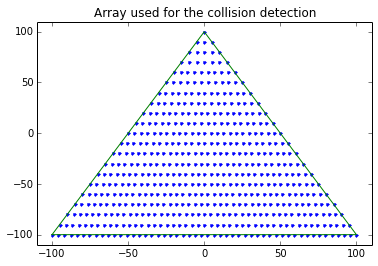

In [40]:
%matplotlib inline
plt.plot(poc[:,0],poc[:,1],'.')
plt.plot(po[:,0],po[:,1])
plt.xlim(-110,110)
plt.ylim(-110,110)
plt.title("Array used for the collision detection")
plt.show()

In [41]:
def explosion(pos,stretch,Nr=100):
    ex = numpy.zeros((Nr*2,2))
    ex[::2,0] = (numpy.random.rand(Nr)-0.5)*stretch
    ex[::2,1] = (numpy.random.rand(Nr)-0.5)*stretch
    return numpy.copy(ex+pos)

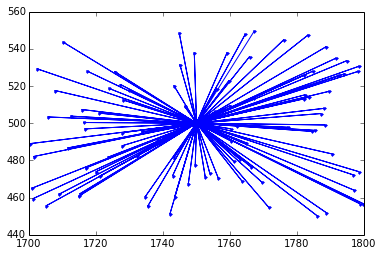

In [42]:
%matplotlib inline
ex=explosion(pos2,100,Nr=100)
plt.plot(ex[:,0],ex[:,1],'.-')
plt.show()

In [43]:
def update_ships((p1c,p2c,p1,p2),pos1, pos2, ang1, ang2):
    
    p1[:]=po.dot(numpy.array([[numpy.cos(-ang1),-numpy.sin(-ang1)],[numpy.sin(-ang1),numpy.cos(-ang1)]]))+pos1
    p1c[:]=poc.dot(numpy.array([[numpy.cos(-ang1),-numpy.sin(-ang1)],[numpy.sin(-ang1),numpy.cos(-ang1)]]))+pos1
#     p1f=numpy.copy(p1[2])

    p2[:]=po.dot(numpy.array([[numpy.cos(ang2),-numpy.sin(ang2)],[numpy.sin(ang2),numpy.cos(ang2)]]))+pos2
    p2c[:]=poc.dot(numpy.array([[numpy.cos(ang2),-numpy.sin(ang2)],[numpy.sin(ang2),numpy.cos(ang2)]]))+pos2
#     p2f=numpy.copy(p2[2])

In [94]:
def update_fire(parameters,fire1=False,fire2=False):
    
    fire_alive, max_x, max_y, p1f, p2f, p1, p2, ang1, ang2 = parameters
    
    if fire1:
        fire_alive[0]=1

    if fire2:
        fire_alive[1]=1

    if fire_alive[0] and (max_x>p1f[0]>0) and (max_y>p1f[1]>0):
        p1f[0]+=bs*numpy.cos(ang1+numpy.pi/2)
        p1f[1]+=bs*numpy.sin(ang1+numpy.pi/2)
    else:
        fire_alive[0] = 0
        p1f[:]=numpy.copy(p1[2])
        
    if fire_alive[1] and (max_x>p2f[0]>0) and (max_y>p2f[1]>0):
        p2f[0]+=bs*numpy.cos(-ang2+numpy.pi/2)
        p2f[1]+=bs*numpy.sin(-ang2+numpy.pi/2)
    else:
        fire_alive[1] = 0
        p2f[:]=numpy.copy(p2[2])

In [45]:
def verify_collision(parameters,c_thres):
    p1f, p2f, p1c, p2c = parameters
    ship1_c = 0
    ship2_c = 0
    
    if (pos2[0]-po[2,1])<=p1f[0]:
        # it means it's close enough to waste time calculating
        if (((p2c - p1f)**2).sum(axis=1)<=c_thres).any():
            # p2 was hit!
            ship2_c = 1
    
    if (pos1[0]+po[2,1])>=p2f[0]:
        # it means it's close enough to waste time calculating
        if (((p1c - p2f)**2).sum(axis=1)<=c_thres).any():
            # p1 was hit!
            ship1_c = 1

    return ship1_c,ship2_c

In [46]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [96]:
def main_game(team1=[],team2=[]):
    
    %matplotlib osx
    plt.close('all')

    fig,axes=plt.subplots(figsize=(20,10));

    max_x = 2000
    max_y = 1000
    
    team1_xy_step = 10/len(team1)
    team2_xy_step = 10/len(team2)
    
    team1_ang_step = 10*((2*numpy.pi)/360)/len(team1)
    team2_ang_step = 10*((2*numpy.pi)/360)/len(team2)    

    score1 = 0
    score2 = 0

    fire_1=False
    fire_2=False
    
    fire_alive = [0,0]
    
    # Random initial positions
    pos1i=numpy.array([pos1[0],(max_y-2*stretch)*numpy.random.rand()+stretch])
    pos2i=numpy.array([pos2[0],(max_y-2*stretch)*numpy.random.rand()+stretch])

    # Random Initial angles
    ang1i=(-numpy.pi/2)*numpy.random.rand()
    ang2i=(-numpy.pi/2)*numpy.random.rand()


    p1=po.dot(numpy.array([[numpy.cos(-ang1i),-numpy.sin(-ang1i)],\
                           [numpy.sin(-ang1i),numpy.cos(-ang1i)]]))+pos1i
    
    # Used to check collisions against p1
    p1c=poc.dot(numpy.array([[numpy.cos(-ang1i),-numpy.sin(-ang1i)],\
                             [numpy.sin(-ang1i),numpy.cos(-ang1i)]]))+pos1i

    p2=po.dot(numpy.array([[numpy.cos(ang2i),-numpy.sin(ang2i)],\
                           [numpy.sin(ang2i),numpy.cos(ang2i)]]))+pos2i

    # Used to check collisions against p2
    p2c=poc.dot(numpy.array([[numpy.cos(ang2i),-numpy.sin(ang2i)],\
                             [numpy.sin(ang2i),numpy.cos(ang2i)]]))+pos2i

    # Bullet vector
    p1f=numpy.copy(p1[2])
    p2f=numpy.copy(p2[2])
    
    
    ang1n = ang1i
    ang2n = ang2i
            
    max_users = 20
    users_filename = "data/users_cmds.dat"
    users_cmds = numpy.memmap(users_filename, dtype=numpy.int32, mode='r+', shape=(max_users,3)) # overwrites any existent file    
    users_cmds[:,:]=0 # guaranties no commands are active
    
    while True:

        try:
            time.sleep(1/40.)
            
            plt.cla() # Cleans the screen
            
            # Check for shots team1
            if users_cmds[team1,2].any():
                fire_1=True
                users_cmds[team1,2]=0 # resets the trigger
            else:
                fire_1=False

            # Check for shots team2
            if users_cmds[team2,2].any():
                fire_2=True
                users_cmds[team2,2]=0 # resets the trigger
            else:
                fire_2=False

            update_fire((fire_alive, max_x, max_y, p1f, p2f, p1, p2, ang1n, ang2n),\
                        fire1=fire_1,fire2=fire_2)
            
            ang1n=ang1i+numpy.sum(users_cmds[team1,0])*team1_ang_step
            ang2n=ang2i-numpy.sum(users_cmds[team2,0])*team2_ang_step
            
            pos1n=pos1i+[0,numpy.sum(users_cmds[team1,1])*team1_xy_step]
            pos2n=pos2i+[0,numpy.sum(users_cmds[team2,1])*team2_xy_step]
            
            update_ships((p1c,p2c,p1,p2),\
                         pos1=pos1n, pos2=pos2n, ang1=ang1n, ang2=ang2n)
            
            c1,c2=verify_collision((p1f, p2f, p1c, p2c),\
                                  c_thres=50)
            
            axes.plot(p1[:,0],p1[:,1],'g', linewidth=3)
            axes.plot(p1[2,0],p1[2,1],'go',markersize=15)
            axes.plot(p1f[0],p1f[1],'go',markersize=15)

            axes.plot(p2[:,0],p2[:,1],'b', linewidth=3)
            axes.plot(p2[2,0],p2[2,1],'bo',markersize=15)
            axes.plot(p2f[0],p2f[1],'bo',markersize=15)


            if c1:
                for i in range(5):
                    ex1p=explosion(pos1n,2*stretch,Nr=100)
                    plt.plot(ex1p[:,0],ex1p[:,1],'.-')
                    plt.xlim(0,max_x)
                    plt.ylim(0,max_y)
                    plt.title("###### - %d x %d - Team 2" % (score1,score2),fontsize=20)                    
                    plt.pause(0.0001)
                score2+=1
                fire_alive[1]=0
                
            if c2:
                for i in range(5):
                    ex2p=explosion(pos2n,2*stretch,Nr=100)
                    plt.plot(ex2p[:,0],ex2p[:,1],'.-')
                    plt.xlim(0,max_x)
                    plt.ylim(0,max_y)
                    plt.title("Team 1 - %d x %d - ######" % (score1,score2),fontsize=20)
                    plt.pause(0.0001)  
                ex2=True
                score1+=1   
                fire_alive[0]=0       


            plt.xlim(0,max_x)
            plt.ylim(0,max_y)

            plt.title("Team 1 - %d x %d - Team 2" % (score1,score2),fontsize=20)


            # Animate using the normal plot window: %matplotlib osx
            plt.pause(0.0001)
            
        except KeyboardInterrupt:
                print "User keyboard interruption...finishing!"
                plt.close()
                print "Final score: %d x %d" % (score1,score2)
                break # Kills the while...

    return (score1,score2)

In [13]:
!mkdir data

mkdir: data: File exists


In [52]:
# 
# Creates the data files used with mmap
# 

max_users=20
    
# Keeps the user details
users_filename = "data/users_details.dat"
users_details = numpy.memmap(users_filename, dtype="S120", mode='w+', shape=(max_users,3)) # overwrites any existent file
# Column 0 has user name (20)
# Column 1 has user HTTP_USER_AGENT (20)
# Column 2 has user REMOTE_ADDR (20)

# Used to read user commands during the game
users_filename = "data/users_cmds.dat"
users_cmds = numpy.memmap(users_filename, dtype=numpy.int32, mode='w+', shape=(max_users,3)) # overwrites any existent file        
# Column 0 has the angle
# Column 1 has the direction
# Column 2 is the trigger

# Initializes the counter / lock
with open('data/lockfile.dat','w+') as f: # overwrites any existent file        
    f.write(str(0)+'\n')

In [53]:
!chmod 777 data

In [54]:
!chmod 666 data/lockfile.dat

In [55]:
!chmod 666 data/users_details.dat

In [56]:
!chmod 622 data/users_cmds.dat

In [19]:
%%file register.py
#!/usr/bin/env python

import fcntl
import os
import cgi
import Cookie
import errno

import numpy

parent = os.getcwd()
max_users=20

arguments = cgi.FieldStorage()

if 'name' in arguments.keys():
    
    user_name = arguments['name'].value
    
    thiscookie = Cookie.SimpleCookie()

    user_agent = os.environ["HTTP_USER_AGENT"]
    user_ip = os.environ["REMOTE_ADDR"]

    # reads the cookie
    if os.environ.has_key('HTTP_COOKIE'):
        thiscookie.load(os.environ['HTTP_COOKIE'])
        if 'name' not in thiscookie.keys(): # new user
            thiscookie['name'] = user_name
            thiscookie['name']['max-age'] = 24*60
            # thiscookie['user_name']['path'] = 'cgi-bin/'
        else:
            thiscookie['name'] = user_name
            thiscookie['name']['max-age'] = 24*60
            # thiscookie['user_name']['path'] = 'cgi-bin/'        

        with open(parent+'/data/lockfile.dat','r+') as f:

            # Traps the script here until it gets the lock
            while True:
                try:
                    # Tries to get the lock
                    fcntl.flock(f, fcntl.LOCK_EX | fcntl.LOCK_NB)

                    total_number = int(f.readline())
                    break
                except IOError as ex:
                    # raise on unrelated IOErrors
                    if ex.errno != errno.EAGAIN:
                        raise
                else:
                    time.sleep(0.1)

            users_filename = parent+"/data/users_details.dat"
            users_details = numpy.memmap(users_filename, dtype="S120", mode='r+', shape=(max_users,3)) # overwrites any existent file

            search_ip = numpy.where(users_details[:,2]==user_ip)[0]

            if search_ip.size>0:
                user_idx = search_ip[0]
            else:
                # Adds one more user if it's new
                total_number+=1
                f.seek(0)
                f.write(str(total_number)+'\n')
                user_idx = total_number-1

            users_details[user_idx,0]=user_name
            users_details[user_idx,1]=user_agent
            users_details[user_idx,2]=user_ip
            users_details.flush()


            # Releases the lock at the end
            fcntl.flock(f, fcntl.LOCK_UN)

        print thiscookie
        print "Content-type: text/html\n\n"
        print "<h2>Welcome to the Staff Development Day!</h2>"
        print "<h3>You are the player number:",total_number,"</h3>"
        print "<h3>Your user name is:",thiscookie['name'].value,"</h3>"
        print "<h3><a href=\'../controller.html'>Go to the Controller!</a></h3>"
        print "And yes, we are watching you :<br>",user_agent,' - ',user_ip
else:
        print "Content-type: text/html\n\n"
        print "<h2>Welcome to the Staff Development Day!</h2>"
        print "<h3>You must insert a user name.</h3>"
        print "<h3><a href=\'../index.html'>Go back to register</a></h3>"        
    

Writing register.py


In [20]:
!mv register.py cgi-bin/register.py
!chmod 755 cgi-bin/register.py

In [102]:
%%file controller.html
<html>
<meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=no">
<head>
    <title>
        Controller
    </title>
    
<script Language="Javascript">

var i_am_free = true;

function send_cmd(cmd)
{
    var oReq = new XMLHttpRequest();

    oReq.onreadystatechange = function(){
        if (oReq.readyState==4){
            i_am_free=true; 
            //console.log(oReq.status);
        }
    }

    if (i_am_free){
        i_am_free=false;        
        oReq.open("GET", "http://" + window.location.hostname + ":8080/cgi-bin/control.py?cmd="+cmd, true);
        oReq.send();
    }
}

</script>    
<style>
.button
{
    background:none;
    border:none;
}
</style>

</head>

<body>
<div style="text-align:center">
  <h1>Control your spaceship!</h1>
 
  <button type="submit"  name="submit" class="button" onmousedown="send_cmd('up');"><img src="arrow_up.jpg"/></button>        
  <button type="submit"  name="submit" class="button" onmousedown="send_cmd('down')"><img src="arrow_down.jpg"/></button>    
  <br>
  <button type="submit"  name="submit" class="button" onmousedown="send_cmd('left')"><img src="left.jpg"/></button>    
  <button type="submit"  name="submit" class="button" onmousedown="send_cmd('right')"><img src="right.jpg"/></button>
  <br>
  <button type="submit"  name="submit" class="button" onmousedown="send_cmd('fire')"><img src="fire.jpg"/></button>
  </div>
    
</body>

</html>

Overwriting controller.html


In [92]:
# Brute force test


from ipyparallel import Client

cli = Client()

lbview = cli.load_balanced_view()
# dview = cli[:]

@lbview.parallel(block=True)
def test(total):
    import requests
    import numpy
    
    cmds = ['up','down','left','right','fire']
    
    errors = 0

    for i in range(total):
        numpy.random.shuffle(cmds)
        r = requests.get('http://localhost:8080/cgi-bin/control.py', params={'cmd':cmds[0]})
        if r.status_code!='200':
            errors+=1

    return errors
        
test.map([40]*len(cli[:]))


In [22]:
%%file index.html
<html>
<meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=no">
<head>
    <title>
        Main page
    </title>
    
</head>

<body>
<div style="text-align:left">
    <h1>Welcome to the game!</h1>
    <form action="cgi-bin/register.py" method="get">
      User name: <input type="text" name="name"><br><br>
      <input type="submit" value="Register">
    </form>
 
</div>
    
</body>

</html>

Overwriting index.html


In [99]:
%%file control.py
#!/usr/bin/env python

import fcntl
import os
import cgi
import Cookie
import errno

import numpy

parent = os.getcwd()
max_users=20

arguments = cgi.FieldStorage()

cmd = arguments['cmd'].value

thiscookie = Cookie.SimpleCookie()

user_agent = os.environ["HTTP_USER_AGENT"]
user_ip = os.environ["REMOTE_ADDR"]

# reads the cookie
if os.environ.has_key('HTTP_COOKIE'):
    thiscookie.load(os.environ['HTTP_COOKIE'])
    if False:#'name' not in thiscookie.keys(): # new user
        print "Content-type: text/html\n\n"
        print "<h1>Your are not registered or your browser does not accept cookies...</h1>"
    else:
        users_filename = parent+"/data/users_details.dat"
        users_details = numpy.memmap(users_filename, dtype="S120", mode='r', shape=(max_users,3))

        users_filename = "data/users_cmds.dat"
        users_cmds = numpy.memmap(users_filename, dtype=numpy.int32, mode='r+', shape=(max_users,3))


        search_ip = numpy.where(users_details[:,2]==user_ip)[0]

        user_idx = search_ip[0]

        if cmd=="up":
            users_cmds[user_idx,1]+=1

        if cmd=="down":
            users_cmds[user_idx,1]-=1

        if cmd=="left":
            users_cmds[user_idx,0]+=1

        if cmd=="right":
            users_cmds[user_idx,0]-=1

        if cmd=="fire":
            users_cmds[user_idx,2]=1

Writing control.py


In [100]:
!mv control.py cgi-bin/control.py
!chmod 755 cgi-bin/control.py

# Start the webserver

In [107]:
import subprocess
import os
# Starts the web server
# !python -m CGIHTTPServer 8080
s1=subprocess.Popen(['python','-m','CGIHTTPServer','8080'],cwd=os.getcwd())

In [108]:
s1.terminate()

# Verifies users

In [50]:
import numpy
max_users = 20
users_filename = "data/users_details.dat"
users_details = numpy.memmap(users_filename, dtype="S120", mode='r', shape=(max_users,3)) # overwrites any existent file

In [59]:
registered = [['Index','Name','Host Details','IP']]
registered += [[n]+i.tolist() for i,n in zip(users_details,range(users_details.shape[0]))]
ListTable(registered)

Index,Name,Host Details,IP
0,R,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.86 Safari/537.36",127.0.0.1
1,,,
2,,,
3,,,
4,,,
5,,,
6,,,
7,,,
8,,,
9,,,


In [98]:
main_game(team1=[0],team2=[0])

User keyboard interruption...finishing!
Final score: 0 x 0


(0, 0)